In [9]:
import os
import glob
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Adjust to your preferred style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [10]:
def parse_combined_json(json_path: str):
    """
    Parses a combined.json file, extracting coverage & atomicity from each entry.
    Extracts alignment_method, model, and threshold based on directory structure.
    """
    # 1) Break the path into components
    parts = json_path.split(os.sep)
    
    # 2) Extract relevant directory names
    try:
        alignment_method = parts[-5]  # 'entailment'
        model_dir = parts[-4]  # e.g., 'gpt_maximize_coverage'
        threshold_str = parts[-3]  # e.g., 'threshold_0.70'
        threshold_val = float(threshold_str.replace("threshold_", ""))
    except (IndexError, ValueError):
        print(f"Warning: Could not extract metadata from path {json_path}")
        return []

    # 3) Load the JSON data
    with open(json_path, "r") as f:
        data = json.load(f)
    
    rows = []

    # 4) Process JSON entries
    for dataset_name, entries in data.items():
        if isinstance(entries, list):
            for item in entries:
                coverage = item.get("coverage", None)
                atomicity = item.get("atomicity", None)
                
                row = {
                    "dataset": dataset_name,
                    "alignment_method": alignment_method,
                    "model": model_dir,
                    "threshold": threshold_val,
                    "coverage": coverage,
                    "atomicity": atomicity
                }
                rows.append(row)
    
    return rows

In [11]:
# Define the base path where JSON results are stored
base_path = "../metrics/alignment_results"  # Adjust if needed

all_records = []

# Recursively search for all combined.json files
pattern = os.path.join(base_path, "**", "combined.json")
json_files = glob.glob(pattern, recursive=True)

for jf in json_files:
    records = parse_combined_json(jf)
    all_records.extend(records)

# Convert to DataFrame
df = pd.DataFrame(all_records)

print(f"Found {len(df)} entries total.")
df.head()

Found 15000 entries total.


,dataset,alignment_method,model,threshold,coverage,atomicity
0,cnndm_test,roberta-large-mnli,kg_based_claims,0.7,0.666667,0.400000
1,cnndm_test,roberta-large-mnli,kg_based_claims,0.7,1.000000,0.642857
2,cnndm_test,roberta-large-mnli,kg_based_claims,0.7,0.500000,0.400000
3,cnndm_test,roberta-large-mnli,kg_based_claims,0.7,1.000000,0.500000
4,cnndm_test,roberta-large-mnli,kg_based_claims,0.7,0.833333,0.875000


In [12]:
# Compute average coverage & atomicity by method, model, threshold
group_cols = ["alignment_method", "model", "threshold"]

summary_df = (
    df.groupby(group_cols, as_index=False)
      .agg({
          "coverage": "mean",
          "atomicity": "mean",
      })
)

summary_df.sort_values(group_cols, inplace=True)
summary_df

,alignment_method,model,threshold,coverage,atomicity
0,roberta-large-mnli,gpt_default,0.7,0.780160,0.569089
1,roberta-large-mnli,gpt_granularity_high,0.7,0.603855,0.480282
2,roberta-large-mnli,gpt_granularity_low,0.7,0.647048,0.517318
3,roberta-large-mnli,gpt_maximize_atomicity,0.7,0.704790,0.501475
4,roberta-large-mnli,gpt_maximize_coverage,0.7,0.914940,0.609895
5,roberta-large-mnli,kg_based_claims,0.7,0.605149,0.495361


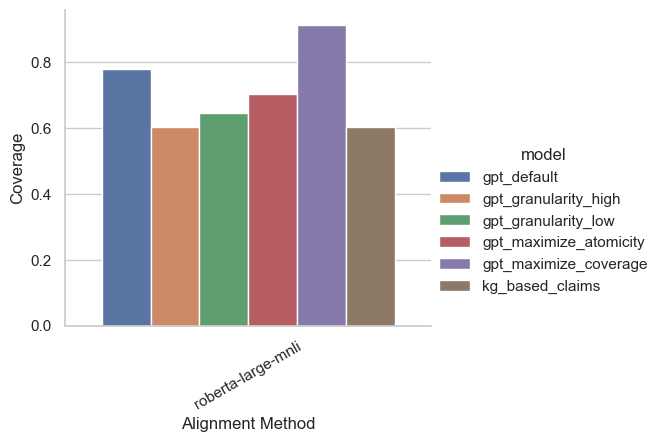

In [13]:
g = sns.catplot(
    data=summary_df, kind="bar",
    x="alignment_method", 
    y="coverage",
    hue="model", 
    # col="threshold",
    height=4, 
    aspect=1.2
)

g.set_titles("Coverage")  
g.set_xlabels("Alignment Method")
g.set_ylabels("Coverage")
g.set_xticklabels(rotation=30)
plt.show()

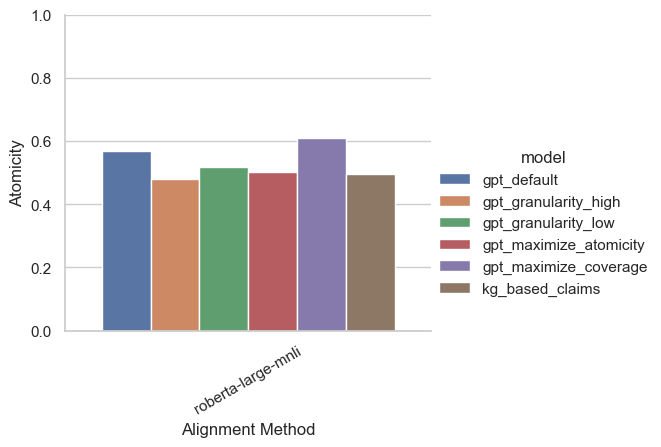

In [14]:
sns.set_style("whitegrid")

g = sns.catplot(
    data=summary_df, kind="bar",
    x="alignment_method", 
    y="atomicity",
    hue="model", 
    # col="threshold",
    height=4, 
    aspect=1.2
)

g.set_titles("Atomicity")
g.set_xlabels("Alignment Method")
g.set_ylabels("Atomicity")
g.set_xticklabels(rotation=30)
g.set(ylim=(0, 1.0))
plt.show()

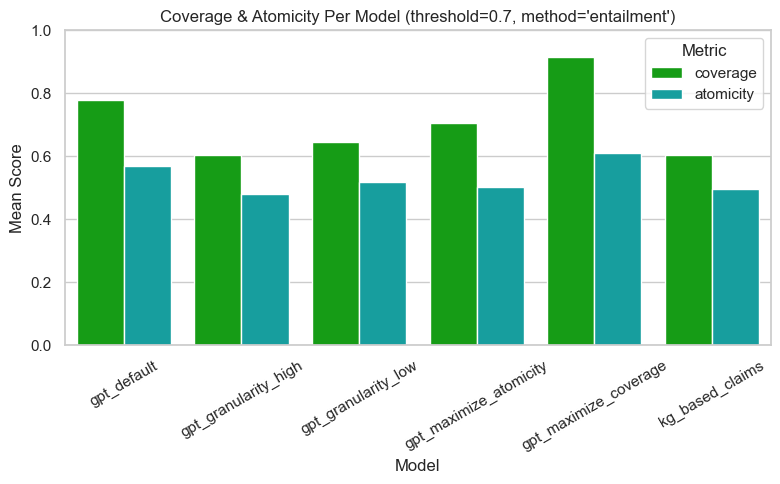

=== Mean Coverage & Atomicity per Model (threshold=0.7, entailment) ===
                 model  coverage  atomicity
           gpt_default  0.780160   0.569089
  gpt_granularity_high  0.603855   0.480282
   gpt_granularity_low  0.647048   0.517318
gpt_maximize_atomicity  0.704790   0.501475
 gpt_maximize_coverage  0.914940   0.609895
       kg_based_claims  0.605149   0.495361


In [15]:
sns.set(style="whitegrid")

# ----------------------------------------------------------------------
# 1. Filter to alignment_method="entailment" and threshold=0.7
# ----------------------------------------------------------------------
df_filtered = df.copy()

# ----------------------------------------------------------------------
# 2. Group by each model and average coverage/atomicity
# ----------------------------------------------------------------------
grouped = df_filtered.groupby("model", as_index=False).agg({
    "coverage": "mean",
    "atomicity": "mean"
})

# ----------------------------------------------------------------------
# 3. Melt coverage & atomicity so we can plot them side by side in one chart
# ----------------------------------------------------------------------
melted = grouped.melt(
    id_vars="model",
    value_vars=["coverage", "atomicity"],
    var_name="metric",
    value_name="score"
)

# ----------------------------------------------------------------------
# 4. Create a grouped bar chart with custom colors
# ----------------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.barplot(
    data=melted,
    x="model",
    y="score",
    hue="metric",
    palette={
        "coverage": "#00B200",  # Green for coverage
        "atomicity": "#00B5B5"  # Teal for atomicity
    }
)

plt.title("Coverage & Atomicity Per Model (threshold=0.7, method='entailment')")
plt.xlabel("Model")
plt.ylabel("Mean Score")
plt.ylim(0, 1)
plt.xticks(rotation=30)  # Rotate x-axis labels for readability
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 5. (Optional) Print the numeric table
# ----------------------------------------------------------------------
print("=== Mean Coverage & Atomicity per Model (threshold=0.7, entailment) ===")
print(grouped.to_string(index=False))

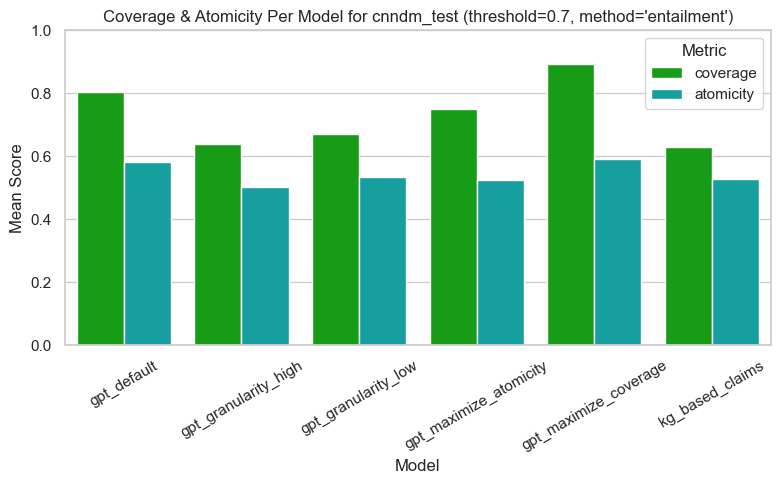

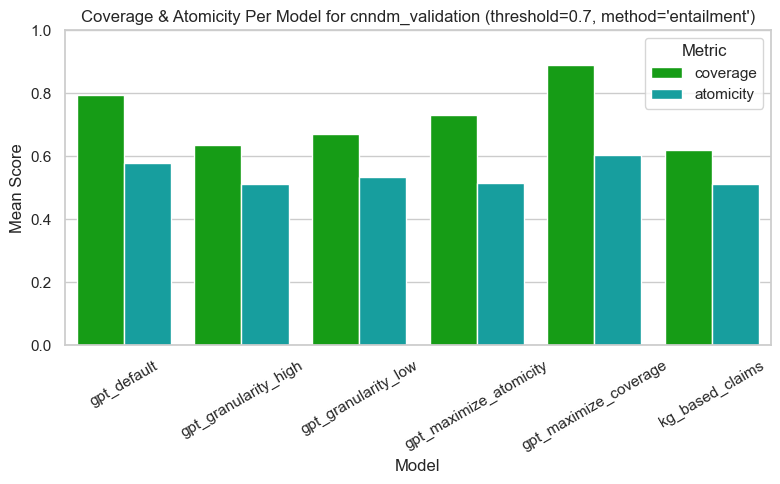

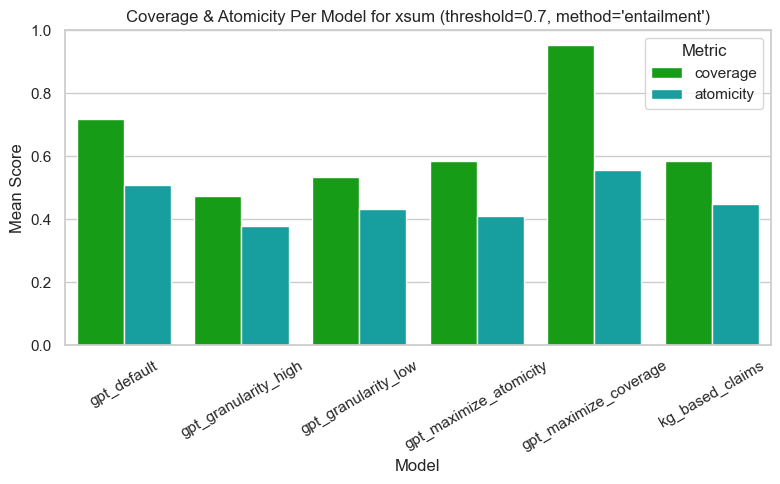

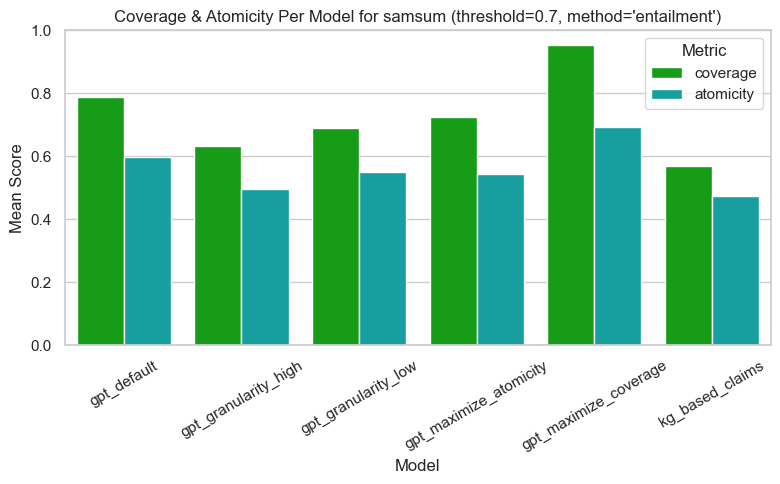

=== Mean Coverage & Atomicity per Model, Split by Dataset (threshold=0.7, entailment) ===
         dataset                  model  coverage  atomicity
      cnndm_test            gpt_default  0.803141   0.580760
      cnndm_test   gpt_granularity_high  0.639881   0.502732
      cnndm_test    gpt_granularity_low  0.670768   0.533822
      cnndm_test gpt_maximize_atomicity  0.750800   0.525602
      cnndm_test  gpt_maximize_coverage  0.893051   0.591746
      cnndm_test        kg_based_claims  0.629933   0.529206
cnndm_validation            gpt_default  0.795140   0.579554
cnndm_validation   gpt_granularity_high  0.635861   0.511393
cnndm_validation    gpt_granularity_low  0.669770   0.534516
cnndm_validation gpt_maximize_atomicity  0.730851   0.514793
cnndm_validation  gpt_maximize_coverage  0.888579   0.603688
cnndm_validation        kg_based_claims  0.620864   0.513034
          samsum            gpt_default  0.789786   0.596613
          samsum   gpt_granularity_high  0.633371   0.49

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid")

# ----------------------------------------------------------------------
# 1. Filter to alignment_method="entailment" and threshold=0.7
# ----------------------------------------------------------------------
df_filtered = df.copy()

# ----------------------------------------------------------------------
# 2. Group by dataset & model, then compute mean coverage & atomicity
# ----------------------------------------------------------------------
grouped = df_filtered.groupby(["dataset", "model"], as_index=False).agg({
    "coverage": "mean",
    "atomicity": "mean"
})

# ----------------------------------------------------------------------
# 3. Melt the data for visualization
# ----------------------------------------------------------------------
melted = grouped.melt(
    id_vars=["dataset", "model"],
    value_vars=["coverage", "atomicity"],
    var_name="metric",
    value_name="score"
)

# ----------------------------------------------------------------------
# 4. Plot: Grouped bar charts per dataset
# ----------------------------------------------------------------------
datasets = df_filtered["dataset"].unique()

for dataset in datasets:
    plt.figure(figsize=(8, 5))
    
    subset = melted[melted["dataset"] == dataset]
    sns.barplot(
        data=subset,
        x="model",
        y="score",
        hue="metric",
        palette={
            "coverage": "#00B200",  # Green for coverage
            "atomicity": "#00B5B5"  # Teal for atomicity
        }
    )
    
    plt.title(f"Coverage & Atomicity Per Model for {dataset} (threshold=0.7, method='entailment')")
    plt.xlabel("Model")
    plt.ylabel("Mean Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=30)
    plt.legend(title="Metric")
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------
# 5. Print the numeric table
# ----------------------------------------------------------------------
print("=== Mean Coverage & Atomicity per Model, Split by Dataset (threshold=0.7, entailment) ===")
print(grouped.to_string(index=False))